<a href="https://colab.research.google.com/github/acse-srm3018/DeeplearningProxy/blob/main/Saturation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul  9 18:11:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
from pycm import *
import numpy as np
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
downloaded = drive.CreateFile({'id':"1A_mWXlDPWwfkjpD6I3faBn3yz_z2KHOh"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('') 


In [8]:
import numpy as np
def load_data(path):
    """
    Function to load datasets in format .NPY
    
    Parameter:
    ----------
    path : string
        The absolute path of where data saved in local system
        
    Return:
    ----------
    loaded_data : ndarray
        The data which was loaded
    """
    loaded_data = np.load(path)
    return loaded_data

In [9]:
# define the absolute path of training datatsat
path_x = '/content/gdrive/MyDrive/Abder_Intersect_Simulations_5_spots/All_X.npy'
path_target = '/content/gdrive/MyDrive/Abder_Intersect_Simulations_5_spots/All_Y.npy'
max_path = '/content/gdrive/MyDrive/Abder_Intersect_Simulations_5_spots/Max_Pressure.npy'
# use load_data function nd above path to loading data
X_data = load_data(path_x)
target_data = load_data(path_target)
Max_pressure = load_data(max_path)

In [10]:
# Split datasets to porosity, permeability and pressurre and ssaturation 
permeability = X_data[:, : , : , :, 0]
porosity = X_data[:, : , : , :, 1]
saturation = target_data[:, :, :, :, 1]
pressure = target_data[:, :, :, :, 0]

In [11]:
!git clone https://github.com/acse-srm3018/DeeplearningProxy.git

Cloning into 'DeeplearningProxy'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 90 (delta 33), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [13]:
from google.colab import files
files.upload()
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/layers.py')
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/unet_uae.py')

In [11]:
input_shape=(100, 100, 2)
depth = 14
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary()

output shape is  (None, 14, 100, 100, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 100, 100, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 16)   304         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 50, 16)   0           batch_normalization[0][0]        
_____________________________________________________

In [12]:
depth = 14
nr = permeability.shape[0]
train_nr = 2250
test_nr = 750
train_x = np.concatenate([permeability[:train_nr,[0], ...],saturation[:train_nr,[0], ...]], axis = 1)
train_y = saturation[:train_nr,:,...]

test_x = np.concatenate([permeability[nr-test_nr:,[0], ...], saturation[nr-test_nr:, [0], ...]], axis = 1)
test_y = saturation[nr-test_nr:,:,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (2250, 100, 100, 2)
train_y shape is  (2250, 14, 100, 100, 1)
test_x shape is  (750, 100, 100, 2)
test_y shape is  (750, 14, 100, 100, 1)


In [14]:
output_dir = '/content/gdrive/MyDrive/Colab Notebooks/saved_models/'
epochs = 300
batch_size = 8
num_batch = int(train_nr/batch_size) 

In [15]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [18]:
opt = Adam(learning_rate=3e-3)
vae_model.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [21]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 15, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = '/content/gdrive/MyDrive/Colab Notebooks/saved_models/saved-model-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', save_freq = 20)

callbacks_list = [lrScheduler, checkPoint]

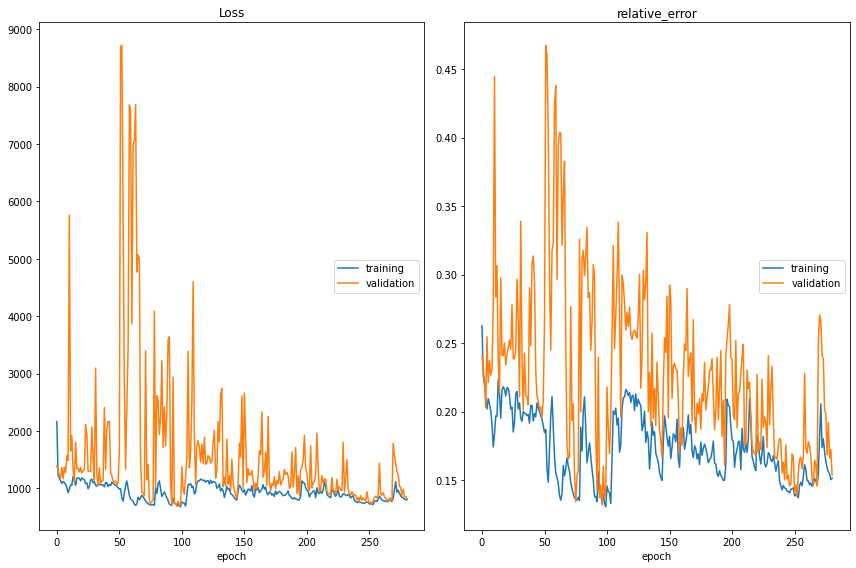

Loss
	training         	 (min:  677.678, max: 2162.214, cur:  800.436)
	validation       	 (min:  696.890, max: 8717.850, cur:  815.926)
relative_error
	training         	 (min:    0.131, max:    0.263, cur:    0.151)
	validation       	 (min:    0.132, max:    0.467, cur:    0.154)
Epoch 282/300
177/282 [=================>............] - ETA: 24s - loss: 785.2340 - relative_error: 0.1486

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks)

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()